In [25]:
import keras.backend as K
import tensorflow as tf
import os 
os.chdir('E:/competition/tianchi/fashionAI/train/')

# 导入必要的库

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import os
import cv2
from tqdm import tqdm,tqdm_notebook
from glob import glob
import multiprocessing
from sklearn.model_selection import train_test_split
from collections import Counter
from scipy import misc
import pydot
from IPython.display import display, Image
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [43]:
from keras.layers import *
from keras.applications import *
from keras.models import Model,Input
from keras.optimizers import Adam
from keras.preprocessing.image import *

# Read the dataset
there are an large-scale image dataset (79000)
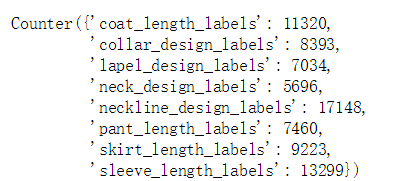

In [26]:
df = pd.read_csv('Annotations/label.csv',header=None)
df.columns = ['filename','label_name','label']
design = ['collar_design', 'lapel_design','neckline_design','neck_design']
length = ['coat_length','pant_length','skirt_length','sleeve_length']
df = df.sample(frac=1).reset_index(drop=True)
df.label_name = df.label_name.str.replace('_labels','')
df = df[(df.label_name == design[0])|(df.label_name == design[1])|(df.label_name == design[2])|(df.label_name == design[3])]
df = df.reset_index(drop=True)
display(df.head())
c = Counter(df.label_name)
c

,filename,label_name,label
0,Images/neck_design_labels/11868b67fafd28485bed...,neck_design,nynnn
1,Images/neckline_design_labels/c7b51748f367848e...,neckline_design,nnnnnynnnn
2,Images/lapel_design_labels/bd5824b0cba139eba9a...,lapel_design,ynnnn
3,Images/neck_design_labels/564f6d6ede2d5c1de592...,neck_design,nnnny
4,Images/lapel_design_labels/c17eaebffe80f1c02ce...,lapel_design,nynnn


Counter({'collar_design': 8393,
         'lapel_design': 7034,
         'neck_design': 5696,
         'neckline_design': 17148})

# the number of classes for each charactristic

In [29]:
label_count = dict([(x,len(df[df.label_name == x].label.values[0])) for x in c.keys()])
label_names = list(label_count.keys())
label_count,label_names

({'collar_design': 5,
  'lapel_design': 5,
  'neck_design': 5,
  'neckline_design': 10},
 ['neck_design', 'neckline_design', 'lapel_design', 'collar_design'])

# 多任务学习的标签设置
对每个样本都生成相同属性长度

In [30]:
fnames = df['filename'].values
width = 224
n = len(df)
y = [np.zeros((n,label_count[x])) for x in label_count.keys()]
for i in tqdm_notebook(range(n)):
    label_name = df.label_name[i]
    label = df.label[i]
    y[label_names.index(label_name)][i,label.find('y')] = 1
    

A Jupyter Widget

In [38]:
testLabel = [y[i][0] for i in range(4)]
testLabel
# 这是第一个样本的标签，它只有neck_design是有标签的

[array([ 0.,  1.,  0.,  0.,  0.]),
 array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([ 0.,  0.,  0.,  0.,  0.]),
 array([ 0.,  0.,  0.,  0.,  0.])]

## resize the image,get the X

In [25]:
def resize_image(path,resolution):
    img = cv2.imread(path)
    (b,g,r) = cv2.split(img)
    img = cv2.merge([r,g,b])
    image = misc.imresize(img,(resolution,resolution,3),mode=None)
    return image

In [26]:
X = [resize_image(fnames[i],width) for i in tqdm_notebook(range(n))]

A Jupyter Widget

# train_val_split

In [28]:
X = np.array(X)
n_train = int(n*0.8)
X_train = X[:n_train]
X_valid = X[n_train:]
y_train = [x[:n_train] for x in y]
y_valid = [x[n_train:] for x in y]

## display images

In [31]:
def display_images(imgs, w=4, h=4, figsize=(24, 12)):
    plt.figure(figsize=figsize)
    for i in range(w*h):
        plt.subplot(h, w, i+1)
        plt.imshow(imgs[i])

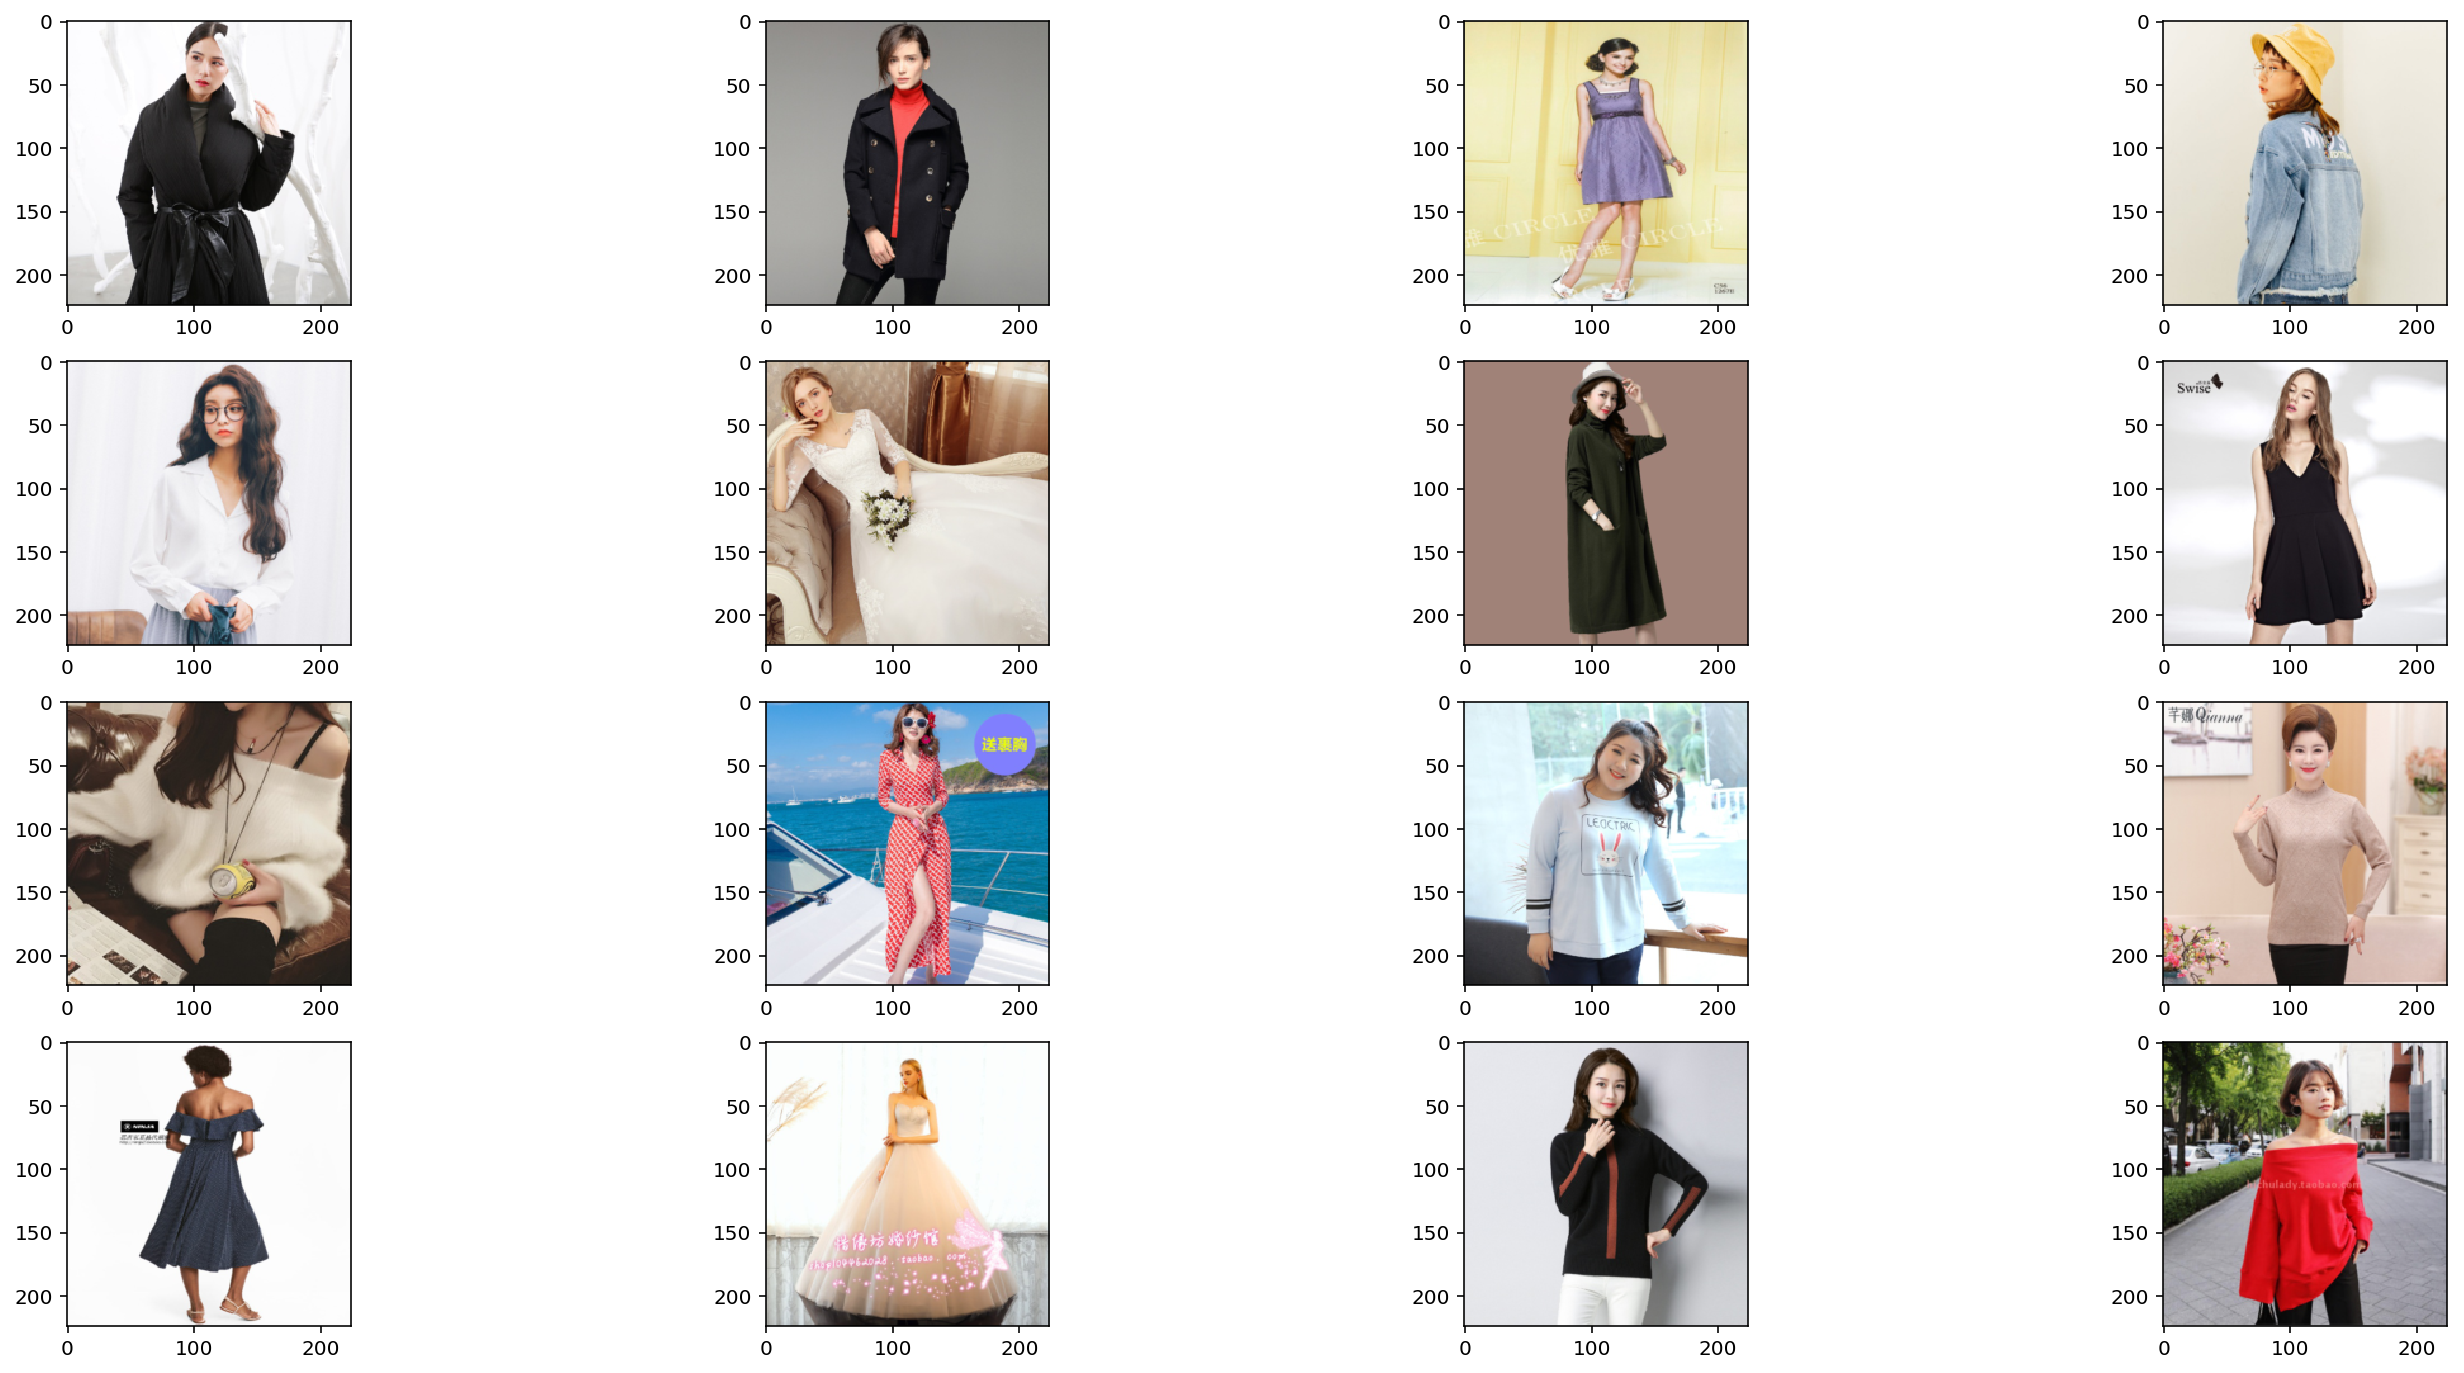

In [32]:
display_images(X[:16])

## data_generator

In [33]:
class Generator():
    def __init__(self, X, y, batch_size=16, aug=False):
        def generator():
            idg = ImageDataGenerator(horizontal_flip=True,
                                     channel_shift_range=10,
                                     rotation_range=20,
                                     zoom_range=0.2)
            while True:
                for i in range(0, len(X), batch_size):
                    X_batch = X[i:i+batch_size].copy()
                    y_batch = [x[i:i+batch_size] for x in y]
                    if aug:
                        for j in range(len(X_batch)):
                            X_batch[j] = idg.random_transform(X_batch[j])
                    yield X_batch, y_batch
        self.generator = generator()
        self.steps = len(X) // batch_size + 1

In [36]:
gen_train = Generator(X_train, y_train, batch_size=8, aug=True)

## Model

In [39]:
#自定义的准确率函数，只计算y_true中有1的任务的误差
def acc(y_true, y_pred):
    index = tf.reduce_any(y_true > 0.5, axis=-1)
    res = tf.equal(tf.argmax(y_true, axis=-1), tf.argmax(y_pred, axis=-1))
    index = tf.cast(index, tf.float32)
    res = tf.cast(res, tf.float32)
    return tf.reduce_sum(res * index) / (tf.reduce_sum(index) + 1e-7)

In [44]:
width = 224
model_name = 'design_resnet50_224'
base_model = ResNet50(include_top=False, weights='imagenet',input_shape=(width, width, 3), pooling='max')
for layer in base_model.layers[:16]:
    layer.trainable = False
    
input_tensor = Input((width, width, 3))
x = input_tensor

x = Lambda(resnet50.preprocess_input)(x)
x = base_model(x)
x = Dropout(0.5)(x)

x = [Dense(count, activation='softmax', name=name)(x) for name, count in label_count.items()]

model = Model(input_tensor, x)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

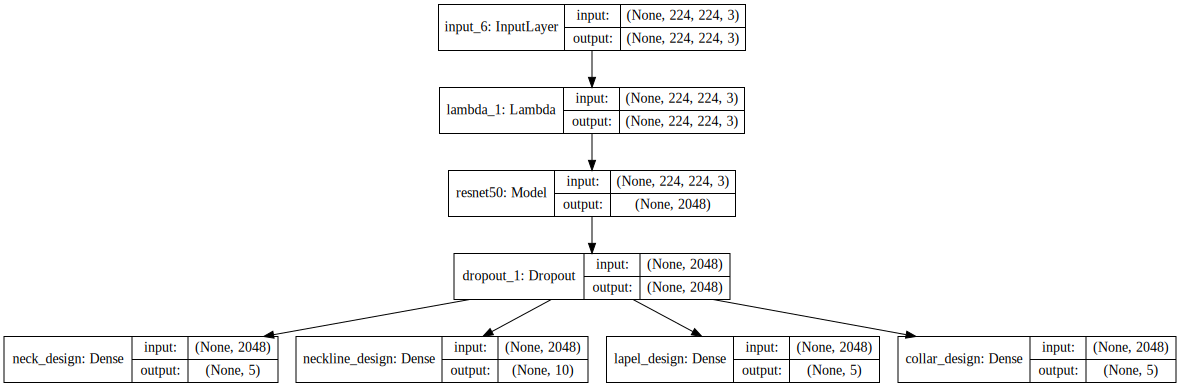

In [45]:
# plot the model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot, plot_model

plot_model(model, show_shapes=True, to_file='model_%s.png'% model_name)
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [ ]:
model.summary()

In [ ]:
model.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=[acc])
model.fit_generator(gen_train.generator, steps_per_epoch=gen_train.steps,epochs=1, validation_data=(X_valid, y_valid))

In [ ]:
model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=[acc])
model.fit_generator(gen_train.generator, steps_per_epoch=gen_train.steps,epochs=2, validation_data=(X_valid, y_valid))

In [ ]:
model.compile(optimizer=Adam(1e-5), loss='categorical_crossentropy', metrics=[acc])
model.fit_generator(gen_train.generator, steps_per_epoch=gen_train.steps,epochs=2, validation_data=(X_valid, y_valid))

In [ ]:
model.compile(optimizer=Adam(1e-6), loss='categorical_crossentropy', metrics=[acc])
model.fit_generator(gen_train.generator, steps_per_epoch=gen_train.steps,epochs=2, validation_data=(X_valid, y_valid))

In [ ]:
model.save('model_%s.h5' % model_name)

## 计算验证集准确率

In [ ]:
y_pred = model.predict(X_valid,batch_size=16,verbose=1)

In [ ]:
#a 代表了样本属于哪一类
a = np.array([x.any(axis=-1) for x in y_valid]).T.astype('uint8')
# np.where If only `condition` is given, return ``condition.nonzero()``.
#  b shape=(4,每个类的样本索引)  表示属于该类的样本的索引位置
b = [np.where((a == np.eye(4)[x]).all(axis=-1))[0] for x in range(4)]

for c in range(4):
    y_pred2 = y_pred[c][b[c]].argmax(axis=-1) #寻找每一个样本的概率最大的一个，作为预测的分类
    y_true2 = y_valid[c][b[c]].argmax(axis=-1)
    print(label_names[c], (y_pred2 == y_true2).mean())